In [1]:
%load_ext autoreload
%autoreload 2

In [15]:
import pandas as pd
import seaborn as sns
import pyarrow.parquet as pq
import pyarrow as pa

In [3]:
train_meta = pd.read_csv('data/filtered_metadata_train.csv')

In [4]:
train_meta.head()

,signal_id,id_measurement,phase,target,peaks
0,0,0,0,0,213
1,1,0,1,0,266
2,2,0,2,0,448
3,3,1,0,1,9083
4,4,1,1,1,15703


In [5]:
select_train_meta = train_meta[train_meta['target'] == 1]
train_meta = train_meta[train_meta['target'] != 1]

In [6]:
print("Number of confirmed PD patterns in original {} signals is {}.".format(len(train_meta), len(select_train_meta)))
print("The ratio is {:.2f}%".format(len(select_train_meta) / len(train_meta) * 100))

Number of confirmed PD patterns in original 8187 signals is 525.
The ratio is 6.41%


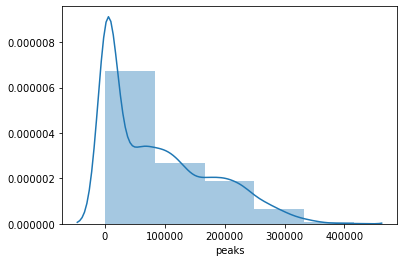

In [7]:
sns.distplot(train_meta['peaks'], bins = 5);

In [8]:
select_train_meta = select_train_meta.append(train_meta[train_meta['peaks'] >= 245000].sample(n=525))
select_train_meta = select_train_meta.append(train_meta[(train_meta['peaks'] >= 150000) & (train_meta['peaks'] <= 244999)].sample(n=525))
select_train_meta = select_train_meta.append(train_meta[(train_meta['peaks'] >= 50000) & (train_meta['peaks'] <= 149999)].sample(n=525))
select_train_meta = select_train_meta.append(train_meta[train_meta['peaks'] < 50000].sample(n=525))

In [9]:
len(select_train_meta)

2625

In [10]:
select_train_meta.sort_index(inplace=True)

In [11]:
select_train_data = None
for chunk_id in range(0,9):
    temp_df = pq.read_pandas('data/filtered_train_{}.parquet'.format(chunk_id)).to_pandas()
    
    for idx, column in enumerate(temp_df.columns):
        if int(column) in list(select_train_meta['signal_id']):
            if isinstance(select_train_data, type(None)):
                select_train_data = pd.DataFrame(data=temp_df[column], columns=[column])
            else:
                select_train_data[column] = temp_df[column]
                
            print("Finished copying signal Id {} of chunk {}".format(column, chunk_id), end="\r")
            
    del temp_df

In [12]:
select_train_data.shape

(500000, 2625)

In [13]:
select_train_meta.to_csv('data/select_train_meta.csv', index=False)

In [16]:
select_train_pq = pa.Table.from_pandas(select_train_data)
pq.write_table(select_train_pq, 'data/select_train.parquet')